In [2]:
from dotenv import load_dotenv
load_dotenv(dotenv_path="../.envfiles/dev.env")

True

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.interpolate import CubicSpline # type:ignore
from src.db import OptoFile
from src.spectra import Sample


subjects = ['s1', 's2', 's3', 's4', 's5', 
            's6', 's7', 's8', 's9', 's10', 
            's11', 's12', 's13', 's14', 's15',
            's16', 's17', 's18', 's19', 's20',
            's21', 's22', 's23', 's24', 's25',
            's26', 's27', 's28', 's29', 's30',
            's31']

In [4]:
from matplotlib import colors
import seaborn as sns

In [57]:
async def load_subject(subject_id:str) -> pd.DataFrame:
    # Index(['subject_id', 'header', 'file_version', 'name', 'creator',
    #        'description', 'created', 'integration_time', 'laser_power',
    #        'average_number', 'scan_mode', 'scan_interval', 'device_model',
    #        'pixel_num', 'device_sn', 'pretreat', 'pixel', 'raman_shift', 'raw',
    #        'dark', 'dark_subtracted', 'baseline_subtracted', 'prick_time',
    #        'glucose_target', 'is_interpolated', 'glucose_predict', 'id',
    #        'elapsed_seconds'],
    #       dtype='object')
    samples:list[OptoFile] = await OptoFile.fetch_all(subject_id=subject_id)
    assert len(samples) > 0
    df = pd.DataFrame([sample.model_dump() for sample in samples])
    df = df[['subject_id', 'created', 'prick_time', 'glucose_target', 'is_interpolated', 'raman_shift', 'raw', 'dark', 'dark_subtracted', 'baseline_subtracted']]
    if (len(samples) == 1):
        df['glucose_interpolated'] = df.glucose_target
        return df
    df['elapsed_seconds'] = [diff.total_seconds() for diff in df.created - df.iloc[0].created]
    df['glucose_interpolated'] = df.glucose_target.interpolate(method='polynomial', order=2)
    # df_w_value = df[df.glucose_target.isnull() == False]
    # Interpolate missing glucose_target values using Cubic Spline
    # cs = CubicSpline(df_w_value['elapsed_seconds'], df_w_value['glucose_target'], bc_type="natural")
    # print(df.glucose_target.interpolate(method='polynomial', order=2) - cs(df['elapsed_seconds']))
    # df['glucose_interpolated'] = cs(df['elapsed_seconds'])
    # print(f"Loaded subject {subject_id} with {len(df)} samples, of which {len(df_w_value)} have glucose_target values.")
    return df

dataset = [df for df in [await load_subject(subject_id=subject_id) for subject_id in subjects]]


In [16]:
from pathlib import Path
data_path:Path = Path("../../data/")
from src.db import init_db, OptoFile
from src.db._var import delete_db

import pandas as pd
from datetime import datetime, timedelta

In [27]:
for file_path in sorted(data_path.glob("additional/*")):
    filename = file_path.name
    subject_id = filename.split("_")[0]
    glucose = filename.split("_")[1]
    print(subject_id, glucose)
    samples = await OptoFile.fetch_all(subject_id=subject_id)
    if(len(samples) > 0):
        samples[0].glucose_target = float(glucose)
        await samples[0].save()
    else:
        optofile = OptoFile.read_opto_file(file_path, subject_id=subject_id)
        optofile.glucose_target = float(glucose)
        await optofile.save()

s16 92
s17 105
s18 137
s19 168
s20 134
s21 105
s22 131
s23 84
s24 99
s25 222
s26 130
s27 108
s28 102
s29 96
s30 128
s31 102


KeyError: 'elapsed_seconds'

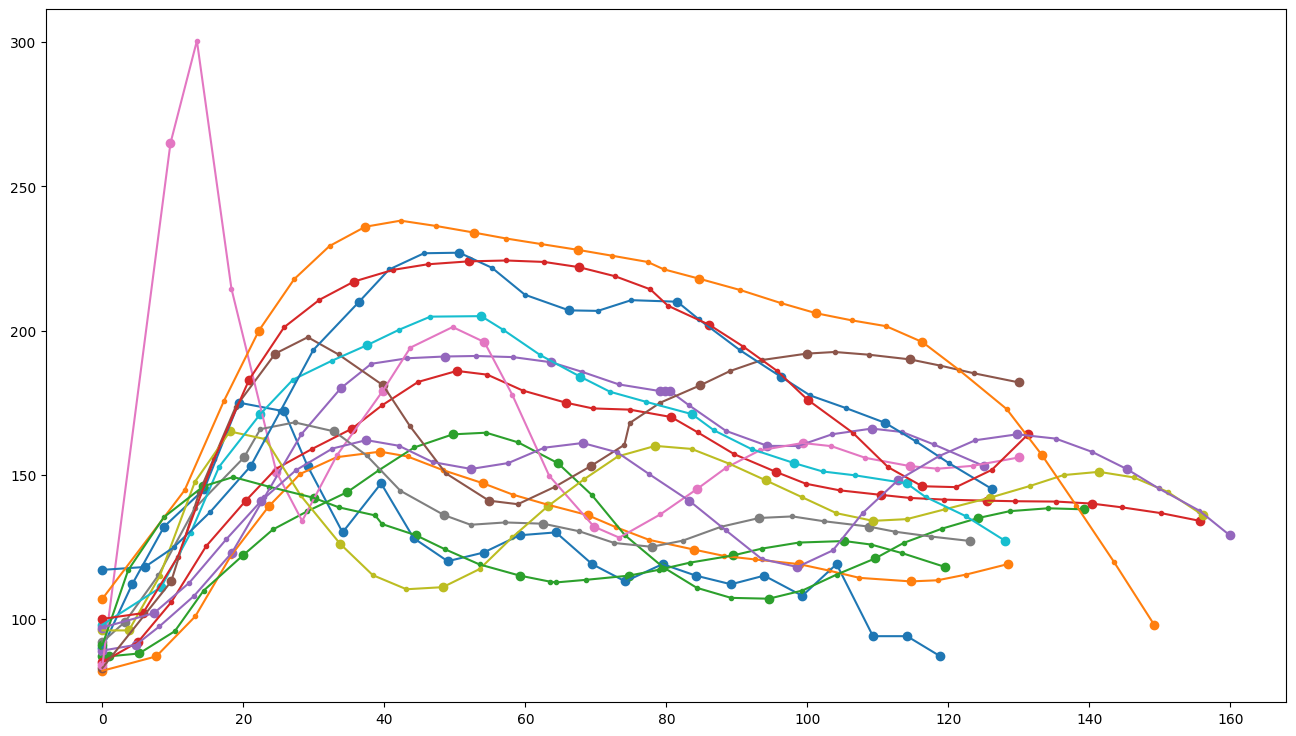

In [58]:

fig, ax = plt.subplots(figsize=(16,9))
color_list = list(colors.TABLEAU_COLORS.values())

count = 0
for index, df in enumerate(dataset):
    elapsed_seconds = df['elapsed_seconds'] / 60.0  # Convert to minutes
    glucoses = df['glucose_interpolated']
    ax.scatter(elapsed_seconds, df.glucose_interpolated, c=color_list[index % len(color_list)], marker='.')
    ax.scatter(elapsed_seconds, df.glucose_target,       c=color_list[index % len(color_list)])
    ax.plot(elapsed_seconds   , df.glucose_interpolated, color=color_list[index % len(color_list)], label=df['subject_id'].iloc[0],)
    # plt.plot(elapsed_seconds, glucoses, marker='o', label=df['subject_id'].iloc[0])



    # if(count >= 1):
    #     break
    count += 1

xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.scatter(0,0, marker='o', label='collected data', c='black')
ax.scatter(0,0, marker='.', label='interpolated data', c='black')
# ax.set_title("A result of OGTT of 8 participants with polynomial interpolation")
ax.set_xlabel("Elapsed time")
ax.set_ylabel("Glycemic (mg/dL)")
# axisx_format = mdates.DateFormatter('%H:%M')
# ax.xaxis.set_major_formatter(axisx_format)
ax.axhspan(60,70, color='grey', alpha=0.1)
ax.axhspan(70,90, color='orange', alpha=0.1)
ax.axhspan(90,160, color='green', alpha=0.1)
ax.axhspan(160,180, color='orange', alpha=0.1)
ax.axhspan(180,350, color='red', alpha=0.1)

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.legend()
ax.grid()
plt.show()

In [59]:
dataset = pd.concat(dataset, ignore_index=True)
dataset

/tmp/ipykernel_2359/4073356034.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataset = pd.concat(dataset, ignore_index=True)


,subject_id,created,prick_time,glucose_target,is_interpolated,raman_shift,raw,dark,dark_subtracted,baseline_subtracted,elapsed_seconds,glucose_interpolated
0,s1,2025-09-25 08:16:44,2025-09-25 08:15:00,90.0,False,"[191.1294, 193.9154, 196.7002, 199.4839, 202.2...","[43066.4, 43066.4, 43066.4, 43066.4, 43066.4, ...","[27174.8, 27174.8, 27174.8, 27174.8, 27174.8, ...","[15891.6, 15891.6, 15891.6, 15891.6, 15891.6, ...","[389.1032, 393.2731, 397.6122, 402.1241, 406.8...",0.0,90.0
1,s1,2025-09-25 08:20:57,2025-09-25 08:20:00,112.0,False,"[191.1294, 193.9154, 196.7002, 199.4839, 202.2...","[43331.2, 43331.2, 43331.2, 43331.2, 43331.2, ...","[27289.8, 27289.8, 27289.8, 27289.8, 27289.8, ...","[16041.4, 16041.4, 16041.4, 16041.4, 16041.4, ...","[379.6331, 383.5506, 387.6291, 391.8719, 396.2...",253.0,112.0
2,s1,2025-09-25 08:25:29,2025-09-25 08:25:00,132.0,False,"[191.1294, 193.9154, 196.7002, 199.4839, 202.2...","[43996.0, 43996.0, 43996.0, 43996.0, 43996.0, ...","[27394.8, 27394.8, 27394.8, 27394.8, 27394.8, ...","[16601.2, 16601.2, 16601.2, 16601.2, 16601.2, ...","[263.6184, 267.2868, 271.1085, 275.0872, 279.2...",525.0,132.0
3,s1,2025-09-25 08:31:10,2025-09-25 08:30:00,145.0,False,"[191.1294, 193.9154, 196.7002, 199.4839, 202.2...","[43745.2, 43745.2, 43745.2, 43745.2, 43745.2, ...","[27242.8, 27242.8, 27242.8, 27242.8, 27242.8, ...","[16502.4, 16502.4, 16502.4, 16502.4, 16502.4, ...","[296.3765, 300.6178, 305.0327, 309.6249, 314.3...",866.0,145.0
4,s1,2025-09-25 08:36:05,2025-09-25 08:35:00,175.0,False,"[191.1294, 193.9154, 196.7002, 199.4839, 202.2...","[43416.6, 43416.6, 43416.6, 43416.6, 43416.6, ...","[27198.2, 27198.2, 27198.2, 27198.2, 27198.2, ...","[16218.4, 16218.4, 16218.4, 16218.4, 16218.4, ...","[222.8331, 226.6198, 230.5636, 234.668, 238.93...",1161.0,175.0
...,...,...,...,...,...,...,...,...,...,...,...,...
430,s27,2026-01-15 09:43:12,NaT,108.0,False,"[191.1294, 193.9154, 196.7002, 199.4839, 202.2...","[57526.6, 57526.6, 57526.6, 57526.6, 57526.6, ...","[41935.6, 41935.6, 41935.6, 41935.6, 41935.6, ...","[15591.0, 15591.0, 15591.0, 15591.0, 15591.0, ...","[1451.2691, 1455.9628, 1460.8325, 1472.1819, 1...",NaN,108.0
431,s28,2026-01-15 09:47:47,NaT,102.0,False,"[191.1294, 193.9154, 196.7002, 199.4839, 202.2...","[59347.4, 59347.4, 59347.4, 59347.4, 59347.4, ...","[43096.2, 43096.2, 43096.2, 43096.2, 43096.2, ...","[16251.2, 16251.2, 16251.2, 16251.2, 16251.2, ...","[1111.399, 1114.991, 1118.7152, 1136.0729, 114...",NaN,102.0
432,s29,2026-01-15 09:54:33,NaT,96.0,False,"[191.1294, 193.9154, 196.7002, 199.4839, 202.2...","[62778.8, 62778.8, 62778.8, 62778.8, 62778.8, ...","[43864.8, 43864.8, 43864.8, 43864.8, 43864.8, ...","[18914.0, 18914.0, 18914.0, 18914.0, 18914.0, ...","[1620.6034, 1624.2536, 1628.0229, 1658.373, 16...",NaN,96.0
433,s30,2026-01-15 03:43:14,NaT,128.0,False,"[191.1294, 193.9154, 196.7002, 199.4839, 202.2...","[22174.0, 22174.0, 22174.0, 22174.0, 22174.0, ...","[7824.2, 7824.2, 7824.2, 7824.2, 7824.2, 7824....","[14349.8, 14349.8, 14349.8, 14349.8, 14349.8, ...","[271.7138, 275.5001, 279.4452, 283.5529, 287.8...",NaN,128.0


Text(0.5, 0, 'Glycemic (mg/dL)')

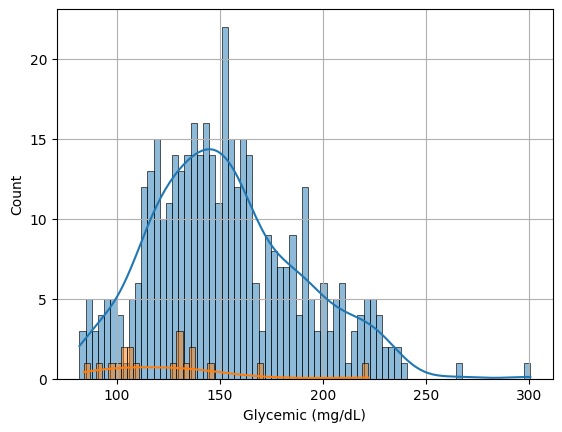

In [120]:
sns.histplot(data=dataset.glucose_interpolated[:416], binwidth=3, kde=True)
sns.histplot(data=dataset.glucose_interpolated[416:], binwidth=3, kde=True)
plt.grid()
plt.xlabel("Glycemic (mg/dL)")

((435, 801), (435,))

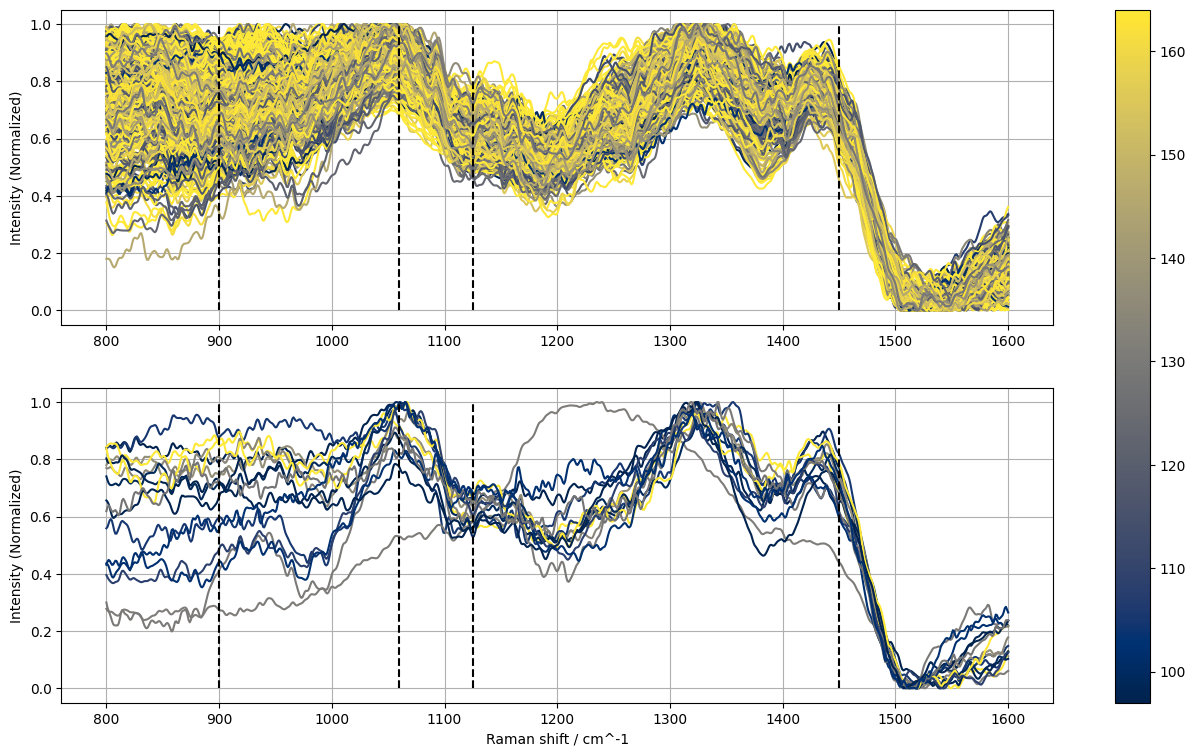

In [144]:
from matplotlib import colormaps, cm
from rampy import baseline as rbaseline
cNorm = colors.Normalize(vmin=min(glucoses), vmax=max(glucoses))
cMap = cm.ScalarMappable(norm=cNorm, cmap=colormaps['cividis'])
colormaps['cividis']
fig,ax = plt.subplots(2,1,figsize=(16,9))
X = []
y = []
cs = []
X_old = []
y_old = []
cs_old = []
X_new = []
y_new = []
cs_new = []
color = cMap.to_rgba(dataset.glucose_interpolated)

for row in dataset.itertuples():
    sample = Sample(
        x=np.array(row.raman_shift),
        y=np.array(row.baseline_subtracted),
        interpolate=False,
        verbose=True
    )
    sample.despike(window_length=10,threshold=5)
    sample.interpolate(step=1)
    sample.extract_range(low=750, high=1650)
    sample.smoothing(window_length=60, polyorder=1)
    signal_y, by = rbaseline(sample.x, sample.y, roi=[[905, 915],[1050, 1070],[1100, 1150],[1400,1460]])
    sample.y = signal_y.reshape(-1)
    # f911  = sample.at(np.arange(905, 915)).mean()
    # f1060 = sample.at(np.arange(1050, 1070)).mean()
    # f1125 = sample.at(np.arange(1125, 1170)).mean()
    # f1450 = sample.at(np.arange(1440, 1460)).mean()
    sample.normalized(method='minmax')
    sample.extract_range(low=800, high=1600)

    X.append(sample.y)
    y.append(row.glucose_interpolated)
    color = cMap.to_rgba(row.glucose_interpolated)
    if(row.subject_id in ['s1', 's2', 's3', 's4', 's5',
                       's6', 's7', 's8', 's9', 's10',
                       's11', 's12', 's13', 's14', 's15']):
        # sample.plot()
        ax[0].plot(sample.x,sample.y, c=color)
        X_old.append(sample.y)
        y_old.append(row.glucose_interpolated)
        cs_old.append(color)
        # y.append(row.glucose_target)
    else:
        X_new.append(sample.y)
        y_new.append(row.glucose_interpolated)
        cs_new.append(color)
        ax[1].plot(sample.x,sample.y, c=color)
        # y.append(row.glucose_target)
    
fig.colorbar(cMap, ax=ax)
ax[1].set_xlabel('Raman shift / cm^-1')
ax[0].set_ylabel('Intensity (Normalized)')
ax[1].set_ylabel('Intensity (Normalized)')
ax[0].vlines(ymin=0, ymax=1, x=[900, 1060, 1125, 1450], color='black', linestyle='--')
ax[1].vlines(ymin=0, ymax=1, x=[900, 1060, 1125, 1450], color='black', linestyle='--')
ax[0].grid()
ax[1].grid()
X = np.array(X)
y = np.array(y)
X_new = np.array(X_new)
y_new = np.array(y_new)
# X = X[y > 0]
# y = y[y > 0]
X.shape, y.shape

In [145]:
# Comparing the raman signals of the additional group with the training group

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

X_old_pca = pca.transform(X_old)
X_new_pca = pca.transform(X_new)



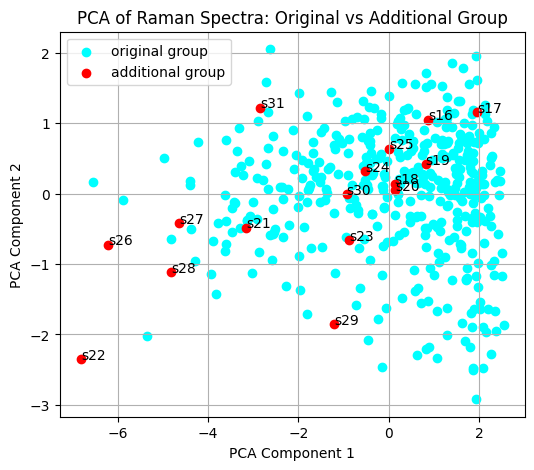

In [146]:
plt.subplots(figsize=(6,5))
plt.scatter(X_old_pca[:,0], X_old_pca[:,1], c='cyan', label='original group')
plt.scatter(X_new_pca[:,0], X_new_pca[:,1], c='red', label='additional group')
for index, sid in enumerate(["s" + str(i) for i in range(16,32)]):
    plt.text(X_new_pca[index,0], X_new_pca[index,1], sid)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.title('PCA of Raman Spectra: Original vs Additional Group')
plt.grid()
plt.show()

In [147]:
from scipy import stats
u_stat, p_value = stats.mannwhitneyu(X_new_pca, X_old_pca)
u_stat, p_value

(array([1901., 3042.]), array([0.00329284, 0.53058969]))

/tmp/ipykernel_2359/952284615.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


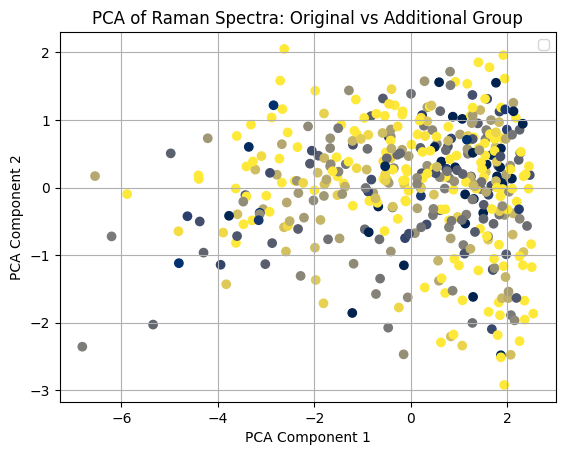

In [149]:
plt.scatter(X_old_pca[:,0], X_old_pca[:,1], c=cs_old)
plt.scatter(X_new_pca[:,0], X_new_pca[:,1], c=cs_new)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.title('PCA of Raman Spectra: Original vs Additional Group')
plt.grid()
plt.show()

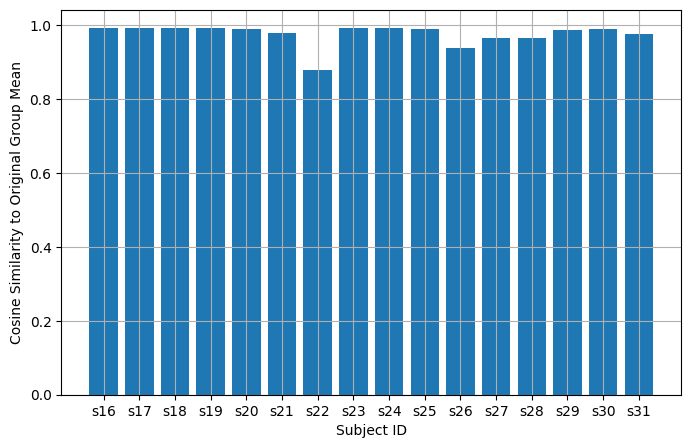

In [150]:
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(X_new, X_old)
similarity_matrix.mean(axis=1)
plt.subplots(figsize=(8,5))
plt.bar(["s" + str(i) for i in range(16,32)], similarity_matrix.mean(axis=1))
plt.xlabel('Subject ID')
plt.ylabel('Cosine Similarity to Original Group Mean')
# plt.title('PCA of Raman Spectra: Original vs Additional Group')
plt.grid()
plt.show()

In [ ]:
import pickle
from src.spectra import Sample
with open("../models/GridSearch-RandomForestRegressor", 'rb') as f:
    model = pickle.load(f)
with open("../models/GridSearch-RandomForestRegressor_pca", 'rb') as f:
    pca = pickle.load(f)

# sample:Sample = await create_sample(spectrum=spectrum)
# pred = float(model.predict(pca.transform(sample.y.reshape(1,-1)))[0])
# return pred

In [66]:
X_new = np.array(X_new)
y_new = np.array(y_new)

In [71]:
model.predict(pca.transform(X_new))

array([135.61272356, 146.34621748, 141.51696864, 145.04726974,
       146.91199606, 152.2234195 , 165.54457692, 154.08135454,
       150.24003905, 166.46728127, 149.71694907, 158.55123133,
       149.86451386, 149.1513247 , 151.95866962, 139.43704111])

In [151]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA

def train(modelcls, X ,y):
    split = RepeatedKFold(n_splits=5, n_repeats=4, random_state=24)
    best_model = None
    best_pca = None
    best_error = np.inf
    count = 0
    errors = []
    for train, test in split.split(X):
        X_train, y_train = X[train], y[train]
        X_test, y_test = X[test], y[test]
        pca = PCA(n_components=25)
        X_train = pca.fit_transform(X_train)
        # Train
        model = None
        if(modelcls == 'mlp'):
            model = MLPRegressor(solver='adam', learning_rate='adaptive', max_iter=100000, hidden_layer_sizes=100, activation='identity')
        else:
            model = modelcls()
        model = model.fit(X_train,y_train.reshape(-1))
        # Test
        X_test = pca.transform(X_test)
        y_hat = model.predict(X_test)
        error = mean_squared_error(y_pred=y_hat,y_true=y_test)
        errors.append(error)
        if(best_error > error):
            best_model = model
            best_error = error
            best_pca = pca
        count = count + 1
    return best_model, best_pca, best_error, np.std(errors)


In [152]:
models = [LinearRegression,
            RandomForestRegressor,
            GradientBoostingRegressor,
            AdaBoostRegressor,
            'mlp']
best_models = []
best_pcas = []
best_errors = []
stds = []
for model in models:
    best_model, best_pca, best_error, std = train(model, X, y)
    print(best_error)
    best_models.append(best_model)
    best_pcas.append(best_pca)
    best_errors.append(best_error)
    stds.append(std)

1025.623488595784
938.5834514926011
962.3782318371511
996.4320789132215
1021.2045703589926


In [153]:
model_names = ['LinearRegression','RandomForestRegressor','GradientBoostingRegressor',"AdaBoostRegressor",'MLPRegressor']
for model_name, best_error, best_model, std in zip(model_names, best_errors, best_models, stds):
    print(model_name, best_error, std, sep='\t')

LinearRegression	1025.623488595784	166.59112247755724
RandomForestRegressor	938.5834514926011	177.19838104692408
GradientBoostingRegressor	962.3782318371511	184.6971946769334
AdaBoostRegressor	996.4320789132215	164.03259611831737
MLPRegressor	1021.2045703589926	167.3720066189124


In [ ]:
from sklearn.model_selection import GridSearchCV
# 2. Instantiate the regressor
rf = RandomForestRegressor(random_state=42)

# 3. Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# 4. Instantiate the GridSearchCV object
# scoring='neg_mean_squared_error' is common for regression tasks
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5, # 5-fold cross-validation
    scoring='neg_mean_squared_error',
    verbose=2, # provides detailed output
    n_jobs=-1 # uses all available cores
)

# 5. Fit the grid search to the data
pca = PCA(n_components=25)
grid_search.fit(pca.fit_transform(X), y)
# 6. Print the best parameters and best score
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best negative MSE score: {grid_search.best_score_}")

# 7. Use the best estimator for predictions
best_pcas.append(pca)
best_models.append(grid_search.best_estimator_)
print(grid_search.best_params_)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END max_depth=None, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END max_depth=None, min_sa

In [166]:
import pickle
for model_name, this_model, this_pca in zip(model_names, best_models, best_pcas):

    with open(f"../models/{model_name}", 'wb') as f:
        pickle.dump(this_model, f)
    with open(f"../models/{model_name}_pca", 'wb') as f:
        pickle.dump(this_pca, f)

In [ ]:
model_names.append("GridSearch-RandomForestRegressor")


In [157]:
y_pred = best_model.predict(X=pca.transform(X))
mse = mean_squared_error(y_pred=y_pred, y_true=y)
r2 = r2_score(y_pred=y_pred, y_true=y)
print(f'Mean Squared Error: {mse}', f'R^2 Score: {r2}')

Mean Squared Error: 1183.022024362112 R^2 Score: 0.09873959153686651


(0, 0)
(0, 1)
(0, 2)
(1, 0)
(1, 1)
(1, 2)


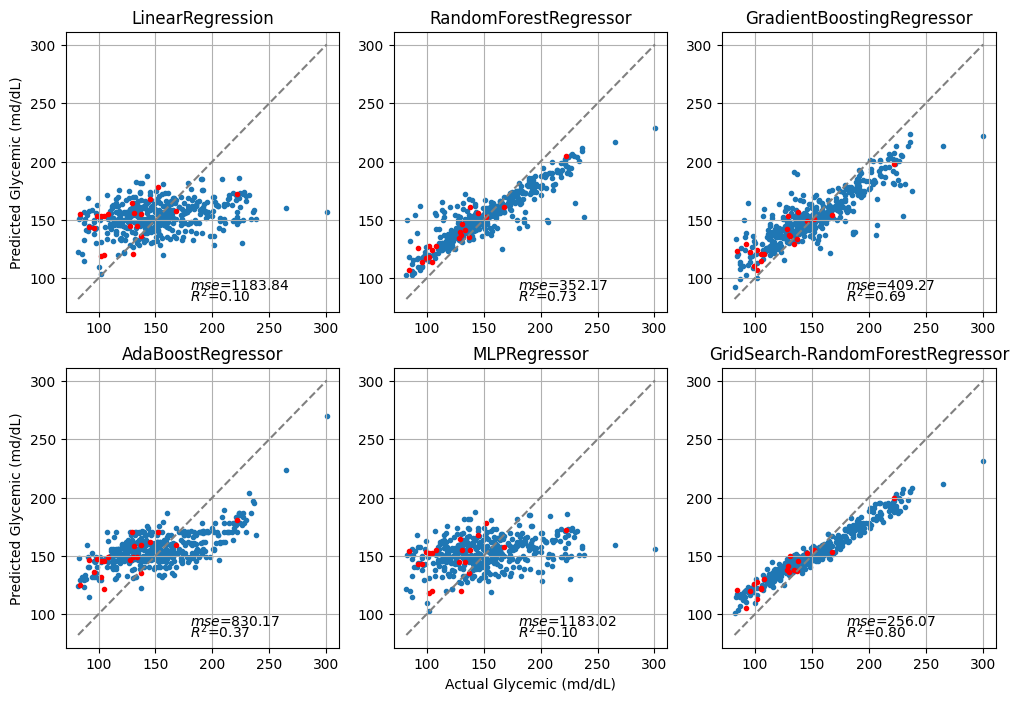

In [170]:
from itertools import product
import pickle
fig,ax = plt.subplots(figsize=(12,8), ncols=3, nrows=2)
for idx, (model_name, model, pca, coord) in enumerate(zip(model_names, best_models, best_pcas, product([0,1],[0,1,2]))):
    print(coord)
    # y_hat = model.predict(X)
    y_hat = model.predict(pca.transform(X))
    # y_scale = scaler.transform(y.reshape(-1,1))
    # print(X.shape, y_hat.shape, y_scale.shape)
    mse = np.round(mean_squared_error(y_pred=y_hat,y_true=y),2)
    r2 = np.round(r2_score(y_pred=y_hat,y_true=y),2)
    ax[coord[0]][coord[1]].scatter(x=y[:415], y=y_hat[:415], marker='.', label='original sample')
    ax[coord[0]][coord[1]].scatter(x=y[415:], y=y_hat[415:], marker='.', label='additional sample', color='red')
    # ax.scatter(x=y[groups == 1], y=y_hat[groups == 1], color='blue', label='old tube')
    # ax.scatter(x=y[groups == 2], y=y_hat[groups == 2], color='red', label='new tube')
    

    min_xy = min(min(y), min(y_hat))
    max_xy = max(max(y), max(y_hat))
    ax[coord[0]][coord[1]].plot([min_xy, max_xy], [min_xy, max_xy], linestyle='--', color='grey')
    # if(model_name == 'LinearRegression'):
    #     ax[coord[0]][coord[1]].text(180,0,s=f'$R^2$={r2:.2f}')
    #     ax[coord[0]][coord[1]].text(180,20,s=f'$mse$={mse:.2f}')
    # else:
    ax[coord[0]][coord[1]].text(180,80,s=f'$R^2$={r2:.2f}')
    ax[coord[0]][coord[1]].text(180,90,s=f'$mse$={mse:.2f}')
    if(coord[0] == 2 or (coord[1] == 1 and coord[0] == 1)):
        ax[coord[0]][coord[1]].set_xlabel('Actual Glycemic (md/dL)')
    if(coord[1] == 0):
        ax[coord[0]][coord[1]].set_ylabel('Predicted Glycemic (md/dL)')
    ax[coord[0]][coord[1]].set_title(model_name)
    # ax.legend()
    ax[coord[0]][coord[1]].grid()

    # save model
    with open(f"{model_name}","wb") as f:
        pickle.dump(model, f)
    # save pca
    with open(f"{model_name}_pca","wb") as f:
        pickle.dump(pca, f)
plt.show()



In [167]:
import pickle
from src.spectra import Sample
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
for model_name in model_names:
    with open(f"../models/{model_name}", 'rb') as f:
        model = pickle.load(f)
    with open(f"../models/{model_name}_pca", 'rb') as f:
        pca = pickle.load(f)
    preds = model.predict(pca.transform(X_new))
    print(model_name, mean_squared_error(y_pred=preds, y_true=y_new), r2_score(y_pred=preds, y_true=y_new))
    

LinearRegression 1513.1316802796414 -0.36134682684721886
RandomForestRegressor 299.028840938004 0.7309672587969867
GradientBoostingRegressor 361.20474871320346 0.6750283237662494
AdaBoostRegressor 1146.1001281736103 -0.031132843937275778
MLPRegressor 1494.508296331926 -0.34459158672317725
GridSearch-RandomForestRegressor 365.61362056600643 0.6710617134672171
